In [20]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify
from FKMC.general import shapes 
from FKMC.plotting import spread
plt.style.use('../custom.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [25]:
from FKMC.general import interaction_matrix, solve_H_vectorised
from FKMC.general import index_histogram_array, sort_IPRs, normalise_IPR, smooth, get_nearby_index,  compute_IPR_and_DOS_histograms, interpolate_IPR


energy_histogram_bins = E_bins = np.linspace(-4, 4, 2000 + 1)

t = 1
U = 2
Ns = np.array([1000,])
rng = np.random.default_rng()

Ts = [1.5, 2.5]
Us = [2, 5]
disorder_data = np.array([
    [ #U = 2 U_i = 0
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.8095890000000001, 0.7996353333333337, 0.8024489795918364, 0.7962247499999999, 0.8097218399999999, 0.7909586111111111, 0.8109371733333332, 0.8128113086419754, 0.8081882314049587, 0.8092678847736622])
        ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 2, m2s = [0.17062400000000005, 0.1217746666666667, 0.1011862857142857, 0.103533625, 0.08152208000000001, 0.06948605555555555, 0.06154023111111111, 0.05436165432098765, 0.045623024793388436, 0.040707226337448554]),
        ),
    ],
    [#U = 5 U_i = 1
    Munch(#T = 1.5 T_i = 0
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.8140095, 0.8023942222222225, 0.807825959183673, 0.8145024999999999, 0.81666472, 0.817028611111111, 0.8053220977777776, 0.8104926666666665, 0.8188372727272728, 0.8083993415637856])
    ),
    Munch(#T = 2.5 T_i = 1
        E_bins = E_bins,
        Ns = Ns,
        parameters = Munch(beta = np.nan, U = 5, m2s = [0.15642450000000002, 0.12025133333333335, 0.1100285714285714, 0.104929125, 0.08670792000000001, 0.07406583333333333, 0.06431651555555554, 0.056547012345679014, 0.04651963636363636, 0.04189197256515774])
        ),
    ],
])


for U_i, U in enumerate(Us):
    for T_i, T in enumerate(Ts):
        o = disorder_data[U_i, T_i]
        o.parameters.m2s = np.array(o.parameters.m2s)
        o.parameters.defect_densities = 1 - np.sqrt(o.parameters.m2s)
        o.Mf_moments = o.parameters.m2s[:, None, None] * np.ones(6)[None, None, :]
        o.parameters.update(mu=0.0, t = t, alpha = 1.25, J = 1.0)
        defect_density = o.parameters.defect_densities[-1]
        
        o.DOS, o.dDOS, o.IPR, o.dIPR = np.empty((4, len(Ns), 2000))
        for N_i, N in enumerate(Ns):
            M = 1
            
            CDW = (np.arange(N)%2)[None, :]
            disorder = rng.choice([1,0], p = [0.5,  0.5], size = (M,N))
            defects = rng.choice([1,0], p = [defect_density, 1-defect_density], size = (M,N))
            states = np.where(defects, disorder, CDW) #choose disorder with probability defect_density
            
            scale = 0.5
            
            o.parameters.N = N
            o.parameters.J_matrix = interaction_matrix(**o.parameters)
             

            #NB the states argument should have only 1s and 0s
            #Fc is infinite at infinite temperature
            o.Ff, o.Fc, o.eigenvals, o.eigenvecs = solve_H_vectorised(states, **o.parameters)

             #calculate the IPR measure
            o.raw_IPRs = ((o.eigenvecs * np.conj(o.eigenvecs))**2).sum(axis = -2)

#             DOS, dDOS, IPR, dIPR = compute_IPR_and_DOS_histograms(eigenvals, raw_IPRs, energy_histogram_bins, bootstrap_bins = 1)

#             interpolate_IPR(energy_histogram_bins, unsmoothed_DOS=DOS, IPR=IPR, dIPR=dIPR)

#             #smooth out the spikey IPR values
#             o.DOS[N_i] = smooth(DOS, scale = scale, axis = -1)
#             o.IPR[N_i] = smooth(IPR, scale = scale, axis = -1)

#             o.dDOS[N_i] = smooth(dDOS, scale = scale, axis = -1)
#             o.dIPR[N_i] = smooth(dIPR, scale = scale, axis = -1)

            o.parameters.J_matrix = None
print('done!')

done!


In [3]:
p = Path('~/HPC_data/pickled_data/disorder_data_wavefunctions.pickle').expanduser()
with open(p, 'wb') as f:
    pickle.dump(disorder_data, f, pickle.HIGHEST_PROTOCOL)
    print('Pickling Successful') 

Pickling Successful


In [4]:
p = Path('~/HPC_data/pickled_data/disorder_data_wavefunctions.pickle').expanduser()
with open(p, 'rb') as f:
    disorder_data = pickle.load(f)
    print('UnPickling Successful') 

UnPickling Successful


(1000,)

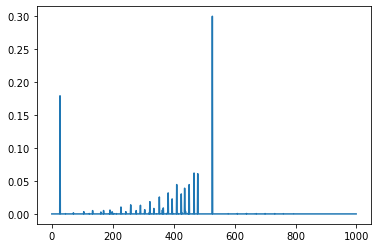

In [5]:
psi = disorder_data[0,0].eigenvecs[0, 0, :]
plt.plot(psi*psi.conj())
psi.shape

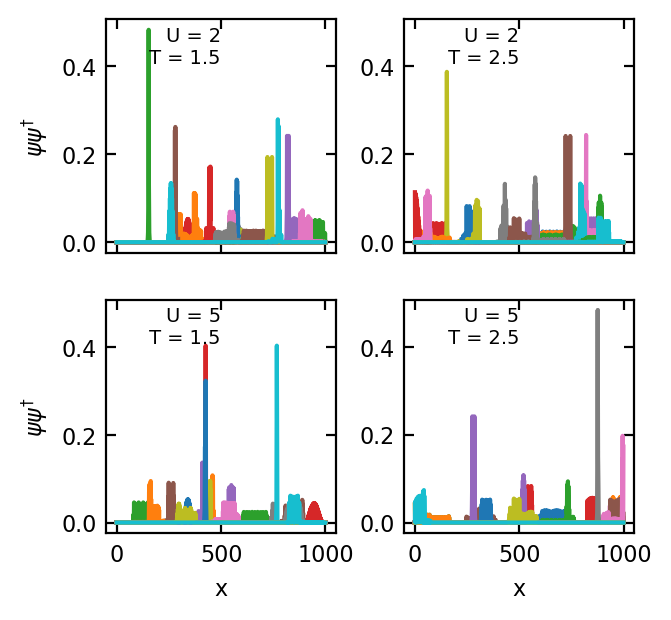

In [31]:
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex = 'all', sharey = 'col', gridspec_kw = dict(wspace = 0.3))

for U_i in [0,1]:
    for T_i in [0,1]:
        o = disorder_data[U_i, T_i]
#         indx = np.argsort()
        
        for i in np.random.randint(1000, size = (20,)):
            psi = disorder_data[0,0].eigenvecs[0, :, i]

            ax = axes[U_i,T_i]
            ax.plot(psi*psi.conj())
        
        phase = f'U = {o.parameters.U}\n T = {Ts[T_i]}'
        ax.text(0.5, 0.97, phase, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', ha='right', color = 'black')
        
        ax.set(xlabel = r"x" if U_i else "",
              ylabel = r"$\psi\psi^{\dagger}$" if not T_i else "",
              )
columnwidth = 246/72.27
f.set_size_inches(columnwidth,columnwidth)

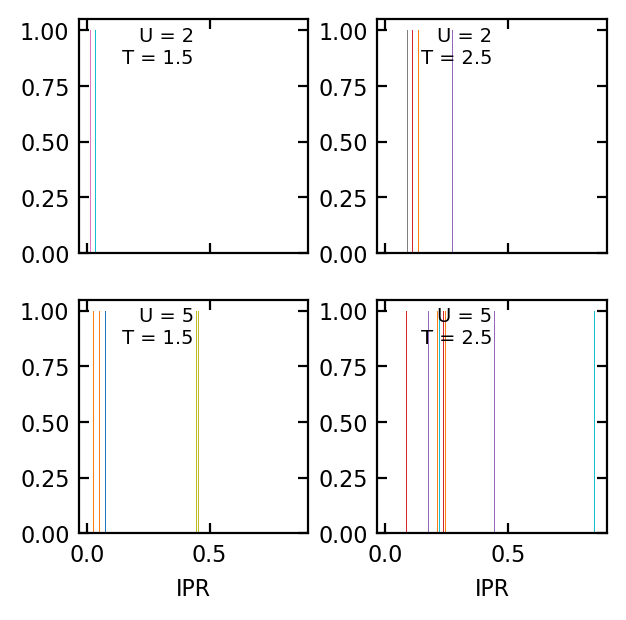

In [33]:
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex = 'all', sharey = 'col', gridspec_kw = dict(wspace = 0.3))

for U_i in [0,1]:
    for T_i in [0,1]:
        o = disorder_data[U_i, T_i]
#         indx = np.argsort()
        
        ax = axes[U_i,T_i]
        ax.hist(o.raw_IPRs, bins = 20)
        
        phase = f'U = {o.parameters.U}\n T = {Ts[T_i]}'
        ax.text(0.5, 0.97, phase, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', ha='right', color = 'black')
        
        ax.set(xlabel = r"IPR" if U_i else "",
              #ylabel = r"Defect Density ($\rho$)" if not T_i else "",
              )


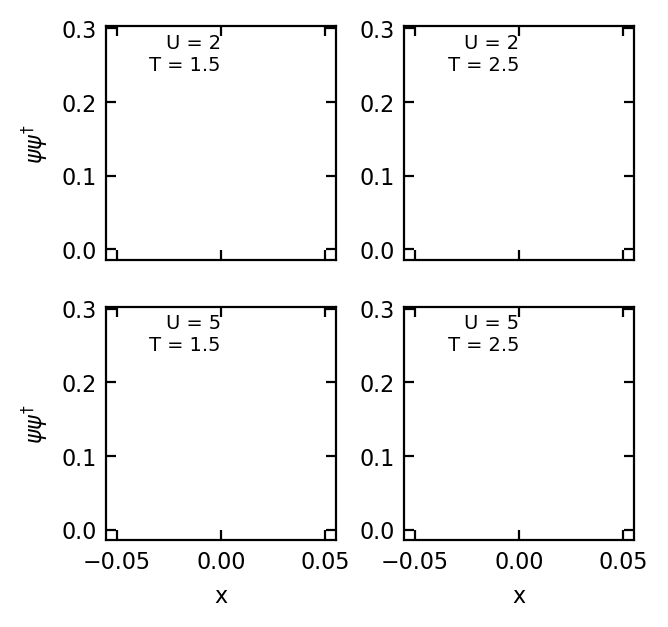

In [32]:
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex = 'all', sharey = 'col', gridspec_kw = dict(wspace = 0.3))

for U_i in [0,1]:
    for T_i in [0,1]:
        o = disorder_data[U_i, T_i]
        indx = np.argsort(o.raw_IPRs)
        
        for i in range(5):
            psi = disorder_data[0,0].eigenvecs[0, indx, -i]

            ax = axes[U_i,T_i]
            ax.plot(psi*psi.conj())
        
        phase = f'U = {o.parameters.U}\n T = {Ts[T_i]}'
        ax.text(0.5, 0.97, phase, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', ha='right', color = 'black')
        
        ax.set(xlabel = r"x" if U_i else "",
              ylabel = r"$\psi\psi^{\dagger}$" if not T_i else "",
              )
columnwidth = 246/72.27
f.set_size_inches(columnwidth,columnwidth)